In [ ]:
import sys, os
import numpy as np
sys.path.append('../src/')
import torch
from MolGraphNetwork import MolGraphNetwork
from scf_guess_tools import Backend

BASIS_PATH = "pcseg-1"
GEOMETRY_Source = "/home/etschgi1/REPOS/Masterarbeit/datasets/QM9/xyz_c7h10o2_sorted"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MGNN = MolGraphNetwork(xyz_source=GEOMETRY_Source,
                       basis=BASIS_PATH,
                       backend=Backend.PY,
                       batch_size=16,
                       hidden_dim=512,
                       train_val_test_ratio=(0.8, 0.1, 0.1), 
                       message_passing_steps=3,
                       edge_threshold_val=5,
                       message_net_layers=3,
                       message_net_dropout=0.1,
                       target="density",
                       data_aug_factor=3,
                       verbose_level=2)
MGNN.load_data(max_samples=500,
               cache_meta = {"method":"dft", "basis":None, "functional": "b3lypg", "guess": "minao", "backend": "pyscf", "cache": "/home/etschgi1/REPOS/Masterarbeit/datasets/QM9/out/c7h10o2_b3lypg_pcseg1/pyscf"})

Setting verbose level to: 2
Loading 6095 files from /home/etschgi1/REPOS/Masterarbeit/datasets/QM9/xyz_c7h10o2_sorted...
Limiting to 500 samples out of 6095 total files.


Loading files: 100%|██████████| 500/500 [00:00<00:00, 1066.21it/s]
Creating graphs: 500it [00:06, 74.55it/s]


Augmenting training set by factor 1.5 -> 200 additional training samples.


Augmenting data: 100%|██████████| 200/200 [00:17<00:00, 11.47it/s]


Total samples: 700, Train: 600 (with 200 / 600 augmented samples), Val: 50, Test: 50
Found 3 center keys (['C', 'H', 'O']) and 6 edge keys (['C_C', 'C_H', 'C_O', 'H_H', 'H_O', 'O_O']) in the training set. -> Totaling 9 unique encoder/decoder.
Normalization factors computed and applied.
Center stats: {'C': (0.15901810980978467, 0.3491067062811784), 'H': (0.376943039894104, 0.4688009978695364), 'O': (0.15833881823789506, 0.3483205718277696)}, Edge stats: {'C_C': (0.005195060268441548, 0.08883001760983442), 'C_H': (0.008284755100834044, 0.08759055895744292), 'C_O': (0.002059219053510427, 0.06410764857519093), 'H_H': (0.011854009449312815, 0.056836850425071625), 'H_O': (0.0027691207348616302, 0.04536916386093946), 'O_O': (-0.0003362722916087268, 0.015907585755933807)}
First train batch: 304 atoms, 4938 edges, 304 center blocks.
Found center block size 105 for atom type O.
Found center block size 105 for atom type C.
Found center block size 15 for atom type H.
Found edge block size 196 for 

In [ ]:
RETRAIN = True
model_name = "MGNN_pcseg1_simple_AUG"
if not RETRAIN and os.path.exists(f"/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/{model_name}.pth"):
    MGNN.load_model(f"/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/{model_name}.pth")
else:
    MGNN.train_model(num_epochs=50, lr=1e-3, weight_decay=1e-5, model_save_path=f"/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/{model_name}.pth")
    MGNN.save_model(f"/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/{model_name}.pth")

Loaded weights from /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_pcseg1_simple_AUG.pth (strict=True)


/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/pcseg1_testing/../src/MolGraphNetwork.py:933: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.loa

In [74]:
import pickle

with open(f"/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/{model_name}.history", "rb") as f: 
    hist = pickle.load(f)
hist["train_loss"]

[180.9233836123818,
 107.46792281301398,
 98.90411718268143,
 93.93867713526676,
 91.70179547761616,
 90.60021731728001]

In [4]:
test_graphs = MGNN.get_graphs("test")

In [67]:
# aux code for testing
sys.path.append('../../')
from utils import plot_mat_comp

randsample_id = np.random.randint(0, len(test_graphs))
print(f"Testing on random sample with id {randsample_id}")
test_graph = test_graphs[randsample_id]

Testing on random sample with id 39


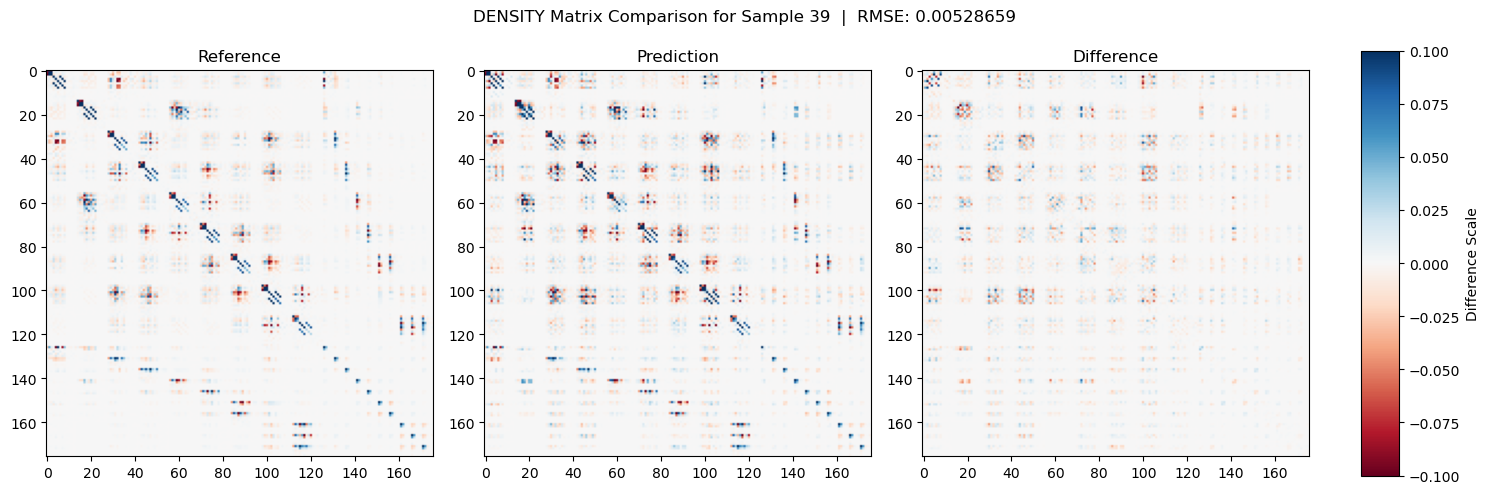

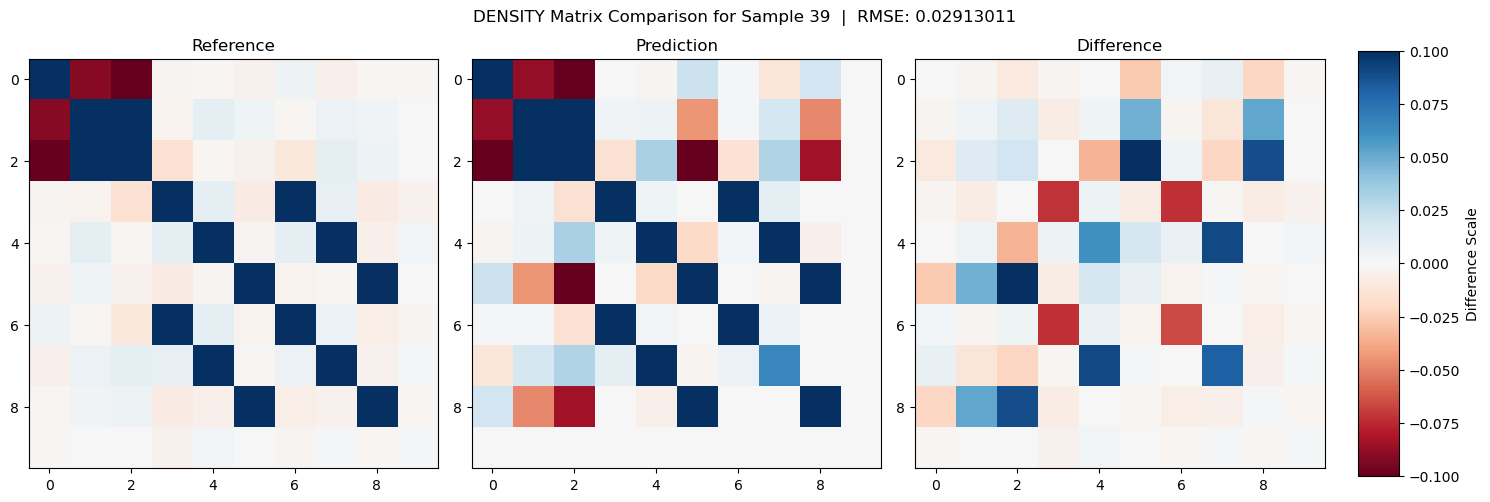

In [68]:
density_pred, density_truth = MGNN.predict([test_graph], include_target=True, transform_to_density=True)[0]
plot_mat_comp(density_pred, density_truth, 
                     title=f"DENSITY Matrix Comparison for Sample {randsample_id}", vmax=0.1)
plot_mat_comp(density_pred[:10,:10], density_truth[:10,:10], 
                     title=f"DENSITY Matrix Comparison for Sample {randsample_id}", vmax=0.1)

ok this already look pretty good for very few training runs!

In [69]:
from scf_guess_tools import load, calculate, guess
from scipy.linalg import eigh
from pyscf import gto, scf

In [70]:
# default calc using minao guess!
rand_file = MGNN.get_files("test")[randsample_id]
print(rand_file)
mol = load(rand_file, basis=BASIS_PATH, backend=Backend.PY)
wf_minao = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess="minao")

/home/etschgi1/REPOS/Masterarbeit/datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_078095.xyz
converged SCF energy = -423.062452938698


In [71]:
mol = load(rand_file, basis=BASIS_PATH, backend=Backend.PY)
wf_own = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess=2*density_pred)

converged SCF energy = -423.062452938845


In [72]:
# ground truth guess
mol = load(rand_file, basis=BASIS_PATH, backend=Backend.PY)
wf_gt = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess=2*density_truth)

converged SCF energy = -423.062452938799


In [73]:
cycles_minao, cycles_own, cycles_gt = wf_minao.native.cycles, wf_own.native.cycles, wf_gt.native.cycles
print(f"Cycles with minao guess: {cycles_minao}, cycles with own guess: {cycles_own}, cycles with ground truth guess: {cycles_gt}")

Cycles with minao guess: 11, cycles with own guess: 11, cycles with ground truth guess: 5


#### ok already very promissing!!! Also Minao Guess looks much the same for center blocks off diag - seem to be better regarding guess!

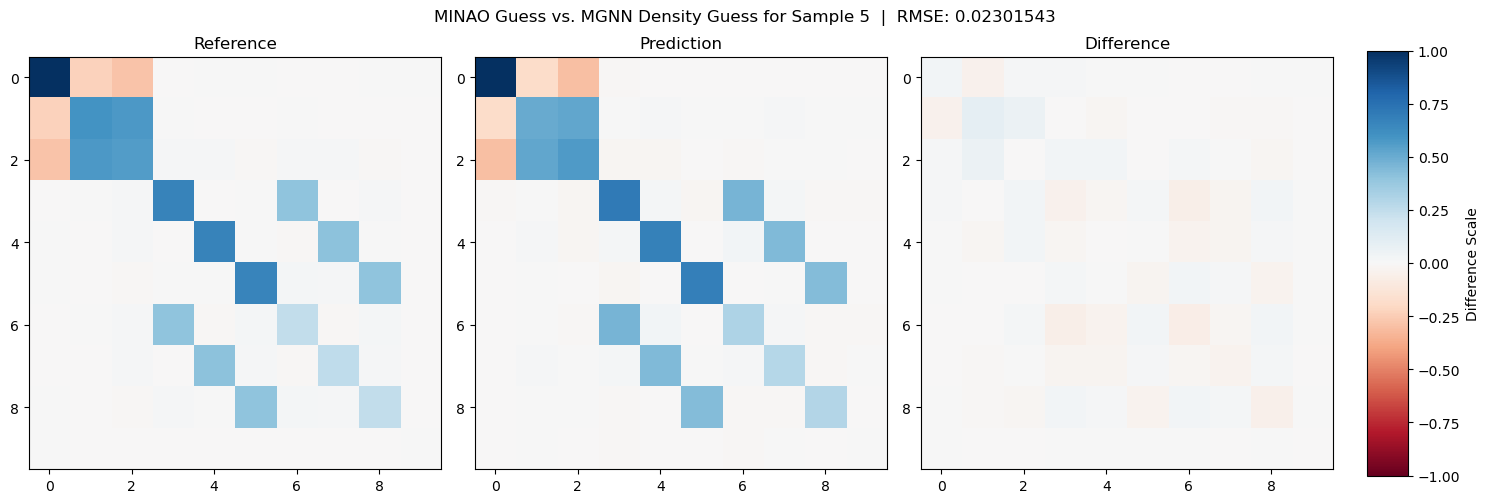

In [64]:
mol = load(rand_file, basis=BASIS_PATH, backend=Backend.PY)
minao_guess = guess(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", scheme="minao")
plot_mat_comp(minao_guess._D[:10,:10], 2*density_pred[:10,:10],
                     title=f"MINAO Guess vs. MGNN Density Guess for Sample {randsample_id}", vmax=1)

# Sanity check & test against ref sim!

In [11]:

mol = load(rand_file, basis=BASIS_PATH, backend=Backend.PY)
wf = calculate(mol, basis=BASIS_PATH, functional="b3lypg", method="dft")
fock_recalc = wf.fock().numpy
density_recalc = wf.density().numpy

KeyboardInterrupt: 

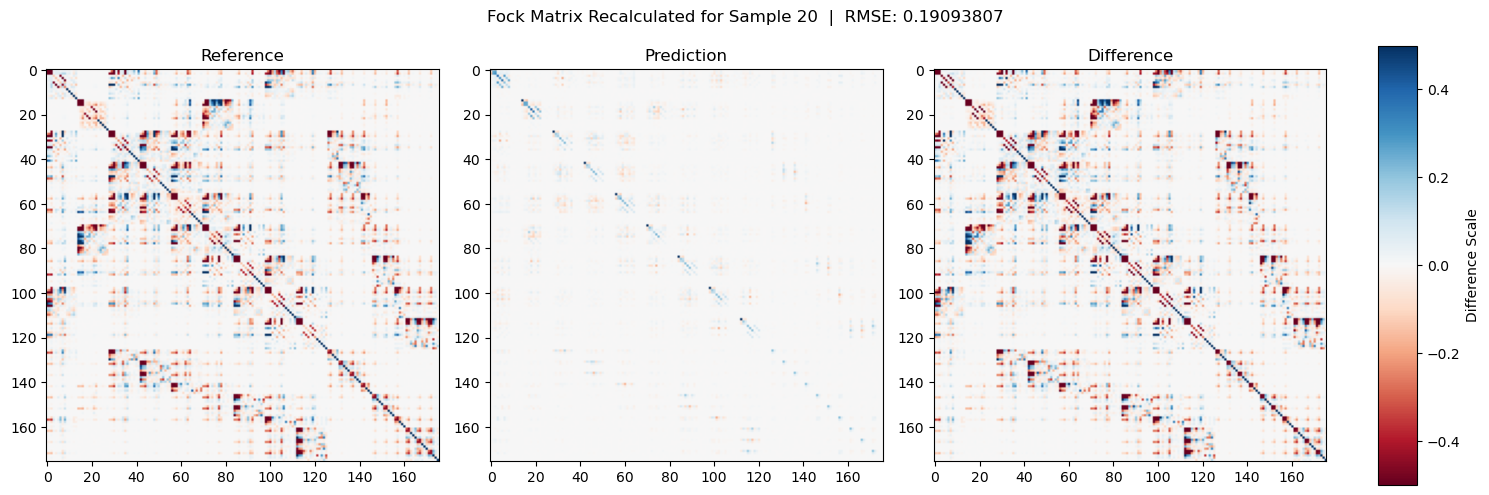

In [ ]:
plot_mat_comp(fock_recalc, fock_true,
                     title=f"Fock Matrix Recalculated for Sample {randsample_id}", vmax=0.5)

ok there is no difference to the recalc vs. ground truth! Next check if we reconstruct the density correctly! 

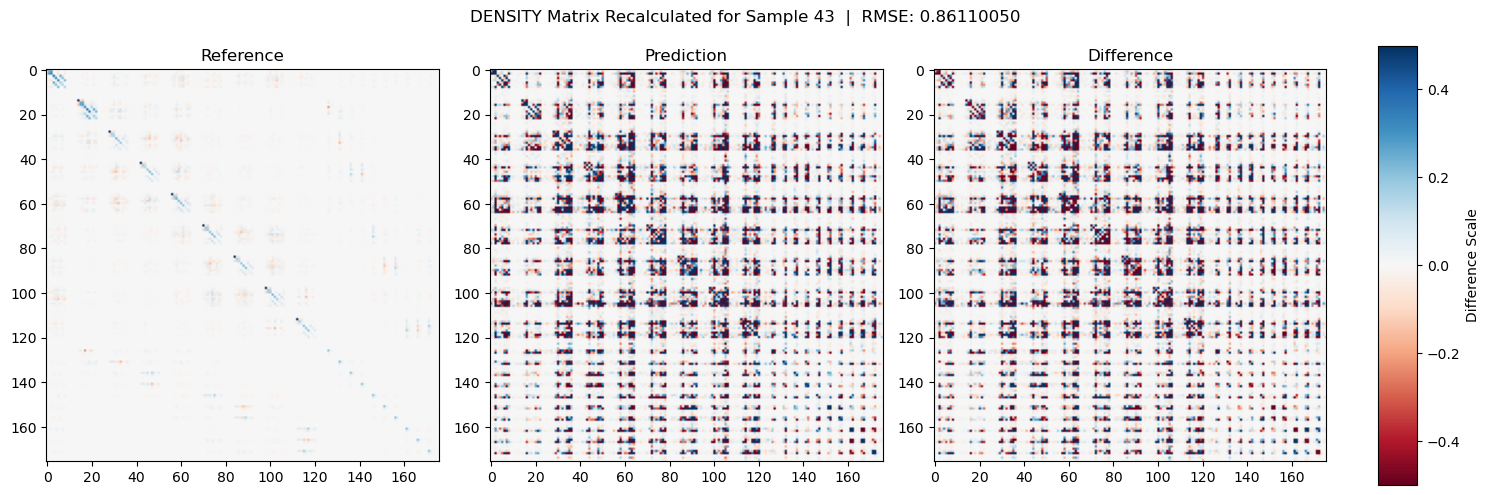

In [ ]:
plot_mat_comp(density_recalc, density_truth, 
                     title=f"DENSITY Matrix Recalculated for Sample {randsample_id}", vmax=0.5)

No there is something odd going on - we fail the reconstruction! 

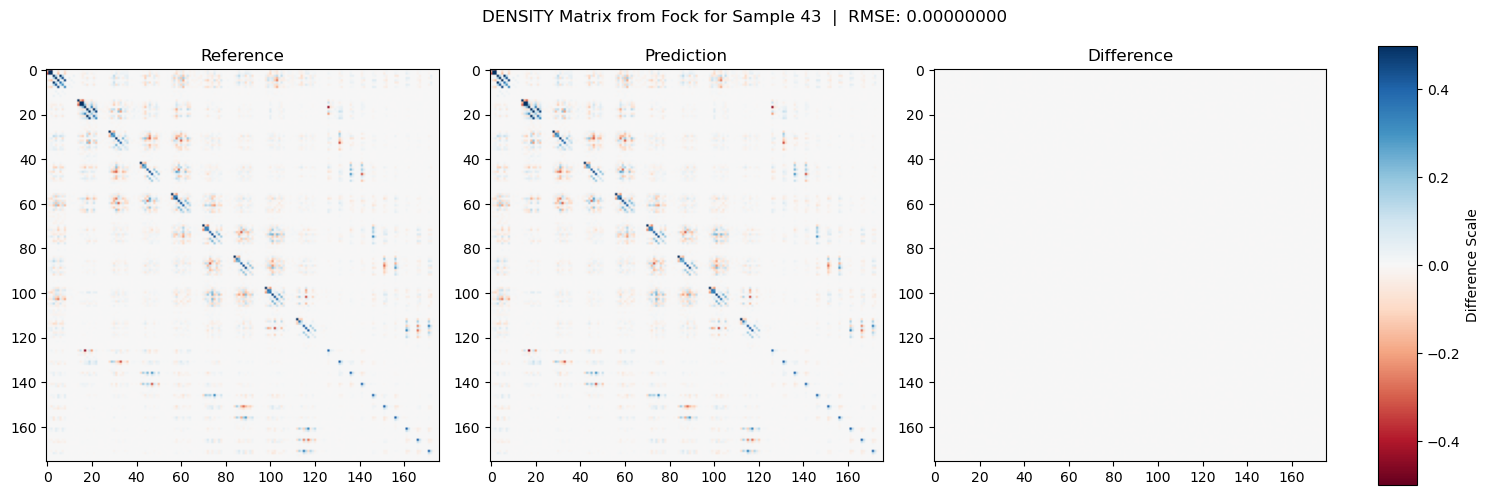

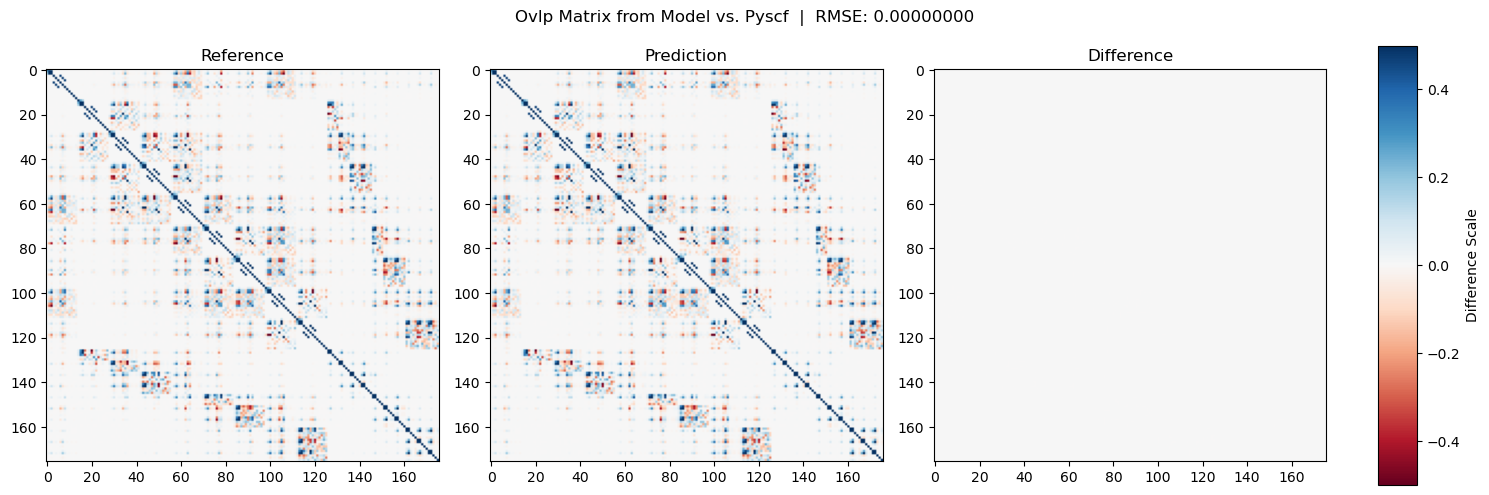

In [ ]:
# manually reconstruct density from fock: 
def check_positive_definite(S, tol=1e-10):
    eigvals = np.linalg.eigvalsh(S)
    is_pd = np.all(eigvals > tol)
    return is_pd

def density_from_fock(fock, overlap, nocc):
    assert check_positive_definite(overlap)
    _, C = eigh(fock, overlap)
    C_occ = C[:, :nocc]
    density = 2 * C_occ @ C_occ.T 
    return density

moln = mol.native
nocc = moln.nelectron // 2
density_from_fock_true = density_from_fock(fock_true, moln.intor("int1e_ovlp"), nocc)
density_from_fock_recalc = density_from_fock(fock_recalc, moln.intor("int1e_ovlp"), nocc)
plot_mat_comp(density_from_fock_recalc, density_from_fock_true, 
                     title=f"DENSITY Matrix from Fock for Sample {randsample_id}", vmax=0.5)
# ovlps from model
ovlp_for_trial = MGNN.get_source_mat("test")[randsample_id]
plot_mat_comp(ovlp_for_trial, moln.intor("int1e_ovlp"), title="Ovlp Matrix from Model vs. Pyscf", vmax=0.5) # ovlp is same! 